In [88]:
!pip install optuna

In [89]:
from classification import Setup, RoadData, RoadModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import numpy as np
import cv2
from pathlib import Path

In [90]:
setup = Setup('/content/ims', '/content/annotations')
train_df = setup.generate_train_df()
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/ims/road416.png,300,400,0,67,98,148,180,images_resized/road416.png,"[73.0, 67.0, 134.0, 147.0]"
1,/content/ims/road867.png,300,400,0,73,125,124,176,images_resized/road867.png,"[93.0, 73.0, 131.0, 123.0]"
2,/content/ims/road773.png,300,400,0,184,188,204,208,images_resized/road773.png,"[141.0, 184.0, 155.0, 203.0]"
3,/content/ims/road14.png,267,400,3,153,202,221,347,images_resized/road14.png,"[151.0, 171.0, 260.0, 248.0]"
4,/content/ims/road371.png,300,400,0,67,219,152,301,images_resized/road371.png,"[164.0, 67.0, 225.0, 151.0]"


(400, 300, 3)


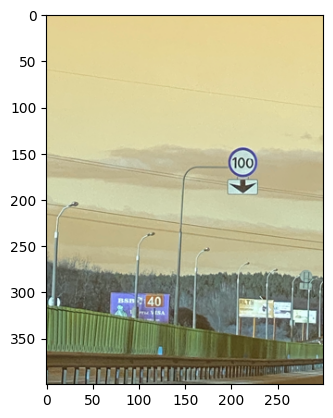

In [91]:
im, Y = setup.test_mask(58)
plt.imshow(im)

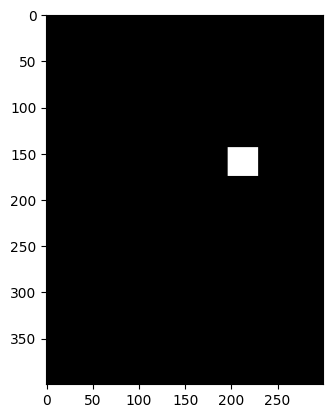

In [92]:
plt.imshow(Y, cmap="gray")

images_resized/road297.png


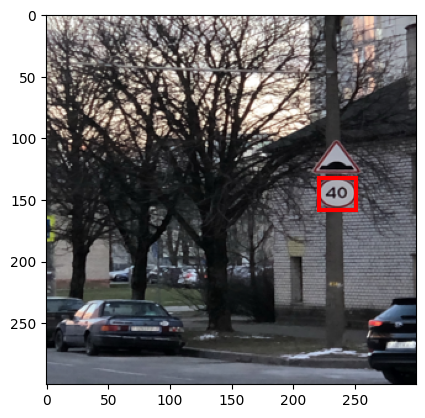

In [93]:
number = 60
setup.test_bb(number)

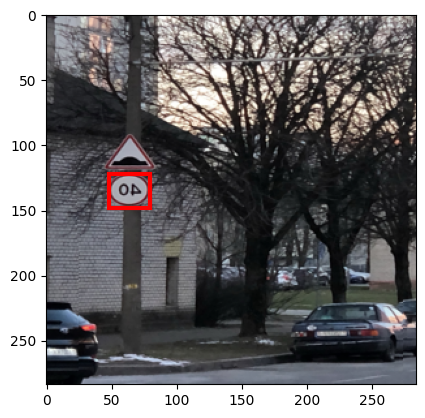

In [94]:
setup.test_transforms(number)

In [95]:
train_df = train_df.reset_index()
X = train_df[['new_path', 'new_bb']]
Y = train_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [96]:
train_ds = RoadData(X_train['new_path'], X_train['new_bb'], Y_train, setup, is_transforms=True)
valid_ds = RoadData(X_val['new_path'], X_val['new_bb'], Y_val, setup)

In [97]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [98]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

def train(network, optimizer, dl):
    network.train()
    total = 0
    sum_loss = 0

    for x, y_class, y_bb in dl:
        len_batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = network(x)

        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
        loss = loss_class + loss_bb

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()

    train_loss = sum_loss / total
    return train_loss


cuda


In [103]:
def test(network, dl):
    network.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y_class, y_bb in dl:
            len_batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()

            out_class, out_bb = network(x)

            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb

            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()

            val_sum_loss += loss.item()
            val_total += len_batch

        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

    return val_acc


In [104]:
def objective(trial):
    net = trial.suggest_categorical("net", ["resnet34", "resnet50"])

    model = RoadModel(net).to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-3, 1)
    optimizer = getattr(torch.optim, optimizer_name)(params, lr=lr)

    for epoch in range(n_epochs):
        train(model, optimizer, train_dl)
        loss = test(model, valid_dl)

        trial.report(loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss

In [105]:
n_epochs = 15
number_of_trials = 15
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [106]:
study = optuna.create_study(direction="maximize", study_name="roadsignclass")
study.optimize(objective, n_trials=number_of_trials)

[I 2023-12-04 09:33:10,144] A new study created in memory with name: roadsignclass
[I 2023-12-04 09:36:41,434] Trial 0 finished with value: 0.2840909090909091 and parameters: {'net': 'resnet50', 'optimizer': 'Adam', 'lr': 0.3084480301759472}. Best is trial 0 with value: 0.2840909090909091.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2023-12-04 09:39:48,817] Trial 1 finished with value: 0.5511363636363636 and parameters: {'net': 'resnet34', 'optimizer': 'Adam', 'lr': 0.2771812097408465}. Best is trial 1 with value: 0.5511363636363636.
[I 2023-12-04 09:43:19,314] Trial 2 finished with value: 0.7159090909090909 and parameters: {'net'

In [107]:

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  3
  Number of complete trials:  12
Best trial:
  Value:  0.7159090909090909
  Params: 
    net: resnet50
    optimizer: RMSprop
    lr: 0.650578410898363


In [111]:
resnet = trial.params['net']

model = RoadModel(resnet).to(device)
params = [p for p in model.parameters() if p.requires_grad]
lr = trial.params['lr']
optimizer = getattr(torch.optim, trial.params['optimizer'])(params, lr=lr)

In [112]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.650578410898363
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [113]:
# model = RoadModel("resnet34").to(device)
# lr = 0.001
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=lr)
for epoch in range(n_epochs):
  train(model, optimizer, train_dl)
  test(model, valid_dl)

In [114]:
im_num = 789

im = cv2.cvtColor(cv2.imread('./images_resized/road{}.png'.format(im_num)), cv2.COLOR_BGR2RGB)
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road{}.jpg'.format(im_num), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [115]:
test_ds = RoadData(
    pd.DataFrame([{'path':'./road_signs_test/road{}.jpg'.format(im_num)}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y'],
    setup
)

In [116]:
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])

In [117]:
model.eval()
out_class, out_bb = model(xx.to(device))
out_class, out_bb

(tensor([[1997.5774,  516.6890, -224.8799, -812.3523]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[126.4663,  99.6103, 157.7320, 159.3173]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [118]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1997.5774], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [119]:
# copied from Setup class
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

[[126  99 157 159]]


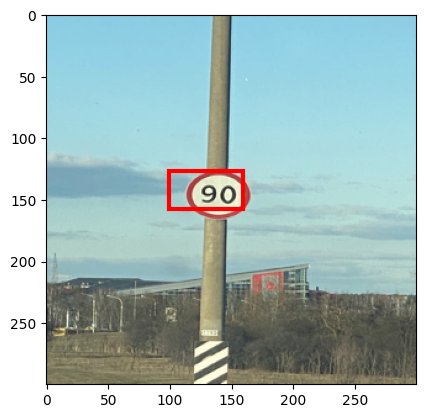

In [120]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
setup.show_corner_bb(im, bb_hat[0])
# show_corner_bb(im, bb_hat[0])
print(bb_hat)